In [1]:
%load_ext autoreload
%autoreload 2
p = print

from os.path import join
import pickle

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error

from crypr.util import get_project_path

In [2]:
SYM = 'BTC'
Ty = 1
Tx = 72
MAX_LAG = 72
data_dir = join(get_project_path(), 'data', 'processed')

In [3]:
"""
Import Data.
"""
def load_preprocessed_data(from_dir, sym):
    X_train = np.load(join(data_dir, 'X_train_{}.npy'.format(SYM)))
    y_train = np.load(join(data_dir, 'y_train_{}.npy'.format(SYM)))
    X_test = np.load(join(data_dir, 'X_test_{}.npy'.format(SYM)))
    y_test = np.load(join(data_dir, 'y_test_{}.npy'.format(SYM)))
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = load_preprocessed_data(data_dir, SYM)

N_FEATURES = X_train.shape[2]
p('Original shape:', X_train.shape)
X_train = X_train.reshape((-1, Tx*N_FEATURES))
X_test = X_test.reshape((-1, Tx*N_FEATURES))
p('2d shape:', X_train.shape)
p(X_train[1])

Original shape: (5586, 72, 18)
2d shape: (5586, 1296)
[ 6.93125000e+03  6.99167000e+03  6.92472000e+03 ...  4.93259062e+03
  3.20590209e+07 -8.72744373e-01]


### XGBRegressor Definition

In [4]:
parameters = {
  'objective': 'reg:linear',
  'learning_rate': .07, 
  'max_depth': 10,
  'min_child_weight': 4,
  'silent': 1,
  'subsample': .7,
  'colsample_bytree': .7,
  'n_estimators': 400,
  'early_stopping_rounds': 50,
}

xgb_reg = XGBRegressor(**parameters)

### Grid CV Definition

In [5]:
grid_params = {
    'max_depth': [3, 4, 5, 6],
}

xgb_grid = GridSearchCV(
    xgb_reg,
    grid_params,
    scoring='neg_mean_absolute_error',
    cv=2,
    n_jobs=-1,
    verbose=True,
)

### Run Tree Model Grid CV

In [6]:
xgb_grid.fit(X_train, y_train)

Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  4.6min finished


GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, early_stopping_rounds=50, gamma=0,
       importance_type='gain', learning_rate=0.07, max_delta_step=0,
       max_depth=10, min_child_weight=4, missing=None, n_estimators=400,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=1,
       subsample=0.7),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [3, 4, 5, 6]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=True)

### Evaluate Best Model

In [7]:
xgb_predict = xgb_grid.predict(X_test)

test_mae = mean_absolute_error(xgb_predict, y_test)
test_mse = mean_squared_error(xgb_predict, y_test)
p('Test Set Results')
p('MAE:', test_mae)
p('MSE:', test_mse)
p('Best parameters: ', xgb_grid.best_params_)

Test Set Results
MAE: 0.4926982313555872
MSE: 0.927891305266811
Best parameters:  {'max_depth': 4}


### Feature Importance (F-score)

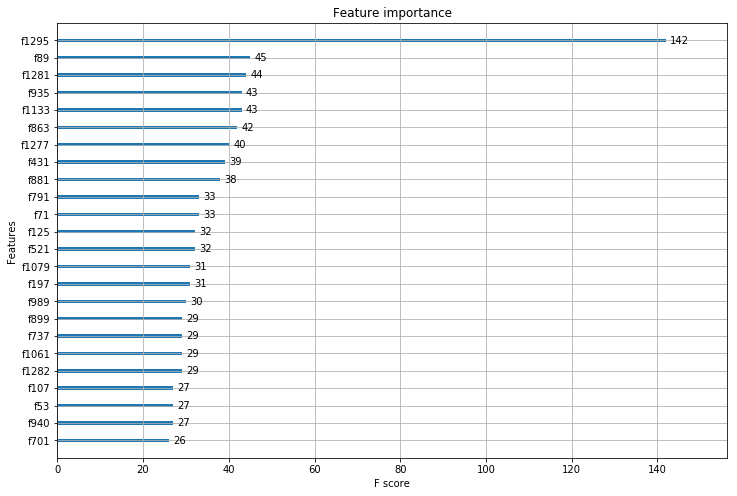

In [8]:
fig, ax = plt.subplots(figsize=(12, 8))
plot_importance(ax=ax, booster=xgb_grid.best_estimator_, max_num_features=24)
plt.show()

### Evaluate Learning Curve
- Re-Train the model with best parameters
- Check model performance every n training examples
- Plot!

In [9]:
"""
Define the Model.
"""
xgb_lc = XGBRegressor(**parameters).set_params(**xgb_grid.best_params_)

"""
Calculate learning curve ()
"""
def calc_xgboost_learning_curve(model, step, X_train, X_test, y_train, y_test) -> tuple:
    """Calculate XGBoostRegressor Learning Curve
    Calculates the mean absolute error for a XGBRegressor 
    per number of training examples fed into the model
    
    Returns:: 
        iterations = number of training examples used to 
            train the model(x-axis of learning curve plot)
        scores_train = mean absolute error of training data
        scores_cv = mean absolute error of cross-validation 
            (test) data
    """
    scorestrain=[]
    scorescv=[]
    iterations=[]

    for i in range(step, len(X_train), step): 
        model.fit(
            X_train[:i], 
            y_train[:i], 
            early_stopping_rounds=50, 
            eval_metric='mae',
            eval_set=[(X_test, y_test)],
            verbose=0,
        )
        scorestrain.append(mean_absolute_error(y_train[:i], model.predict(X_train[:i])))
        scorescv.append(mean_absolute_error(y_test, model.predict(X_test)))
        iterations.append(i)
    return iterations, scorestrain, scorescv

iterations, scorestrain, scorescv = calc_xgboost_learning_curve(xgb_lc, 500, X_train, X_test, y_train, y_test)

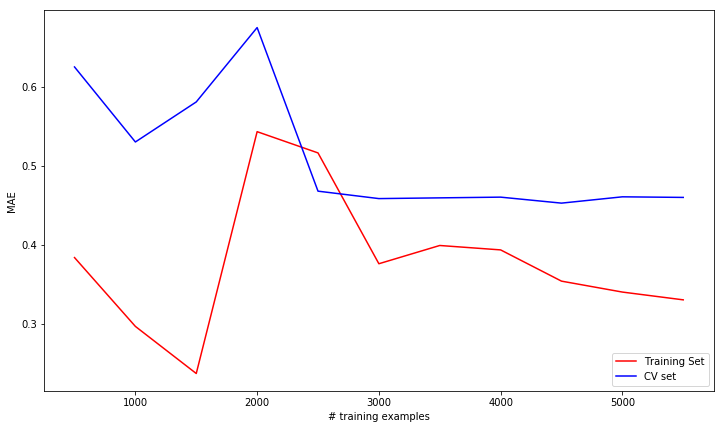

In [10]:
"""
Plot learning curve.
"""
def plot_xgboost_learning_curve(iterations, scorestrain, scorescv) -> None:
    """Plots output of `calc_xgboost_learning_curve`"""
    plt.figure(figsize=(12, 7))
    plt.plot(iterations,scorestrain, 'r')
    plt.plot(iterations,scorescv, 'b')
    plt.xlabel('# training examples')
    plt.ylabel('MAE')
    plt.legend(['Training Set', 'CV set'], loc='lower right')
    plt.show()

plot_xgboost_learning_curve(iterations, scorestrain, scorescv)

In [11]:
# Save model
model_filename = 'tree_model_dev_{}.pkl'.format(SYM)
model_path = join(get_project_path(), 'models', model_filename)
with open(model_path, 'wb') as output_file:
    s = pickle.dump(xgb_grid.best_estimator_, output_file)